In [1]:
import matplotlib.pyplot as plt

import numpy as np
from scipy.signal import decimate

from neurodsp.utils.norm import normalize_sig
from neurodsp.filt import filter_signal

from timescales.sim import sim_branching, sim_asine_oscillation, sim_autoregressive
from timescales.fit import convert_knee_val
from timescales.decompose import CAD, CADGroup, asym_osc_decomposition

### Autoregressive Decomposition
This notebook uses a modified version of "canonical autoregressive decomposition" (CAD) decribed in (Nagesha & Kay, 1994). CAD involves modeling sinusoids separately from AR coefficients. The modification include here adds a parameter allowing non-sinusoidality in the oscillatory term.


#### Aperiodic: AR(p) Model
$$A_{n} = \sum_{k=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

#### Periodic: Non-Sinusoidal Oscillatory Model

$$w_{i} = e^{j \phi_{i}} e^{j 2\pi f_{i} n}$$

$$z_{i} = w_{i} \cdot e^{j c_{i} w+{i}}$$

$$P_{n} = \sum_{i=1}^{s}z_{i}$$

#### Full Model

$$x_{n} = \sum_{i=1}^{s}z_{i} + \sum_{i=1}^{p}a_{k} X_{n-k} + \varepsilon_{n}$$

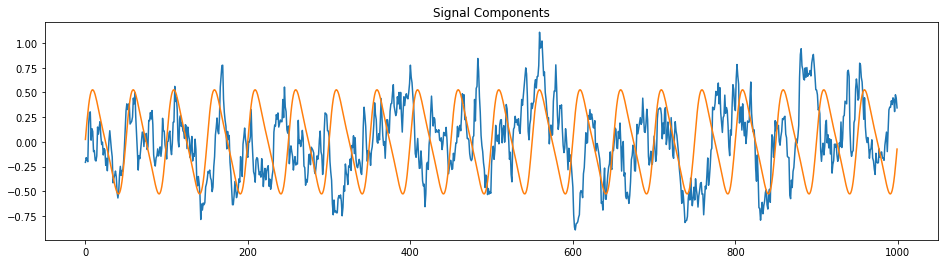

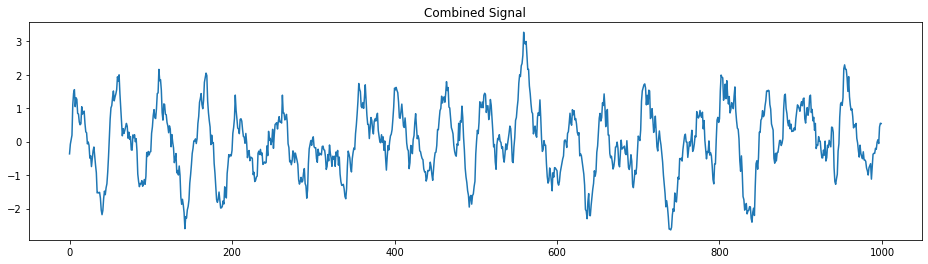

In [2]:
np.random.seed(0)

n_seconds = 1
fs = 1000
tau = convert_knee_val(10)
xs = np.arange(fs)

lfp = sim_branching(n_seconds, fs, tau, 100)
osc = sim_asine_oscillation(xs, fs, 20, .25, -.49, 1)

osc_var = .5
lfp = normalize_sig(lfp, 0, (1-osc_var)) 
osc = normalize_sig(osc, 0, (osc_var)) 

sig = lfp + osc

plt.figure(0, figsize=(16, 4))
plt.title('Signal Components')
plt.plot(lfp/2)
plt.plot(osc/2)

plt.figure(1, figsize=(16, 4))
plt.title('Combined Signal')
plt.plot(sig);


In [3]:
osc_order = 1
ar_order = 2

cad = CAD(sig, fs, osc_order, ar_order)
cad.fit()

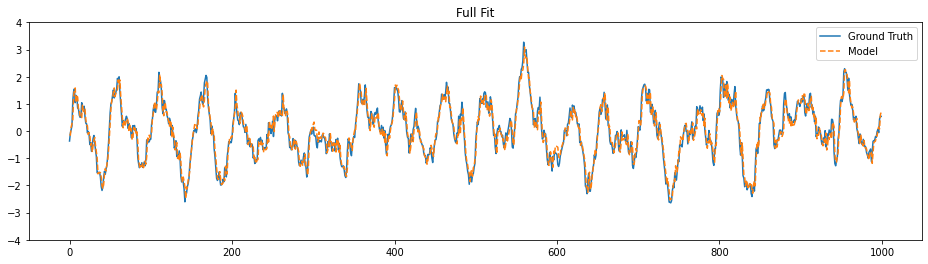

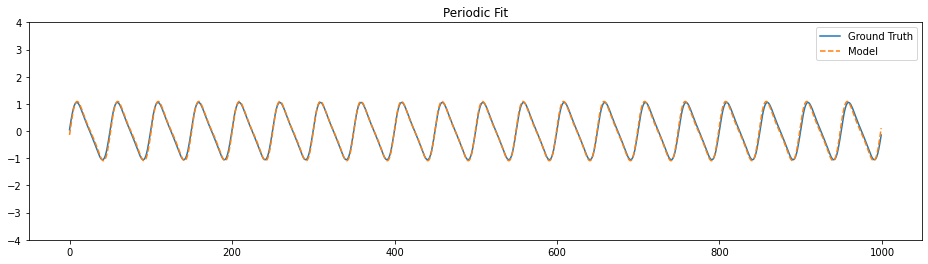

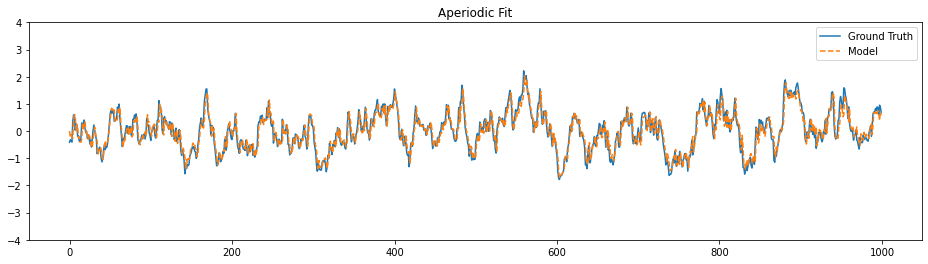

In [4]:
# Plot Results
plt.figure(0, figsize=(16, 4))
plt.title('Full Fit')
plt.plot(sig, label='Ground Truth')
plt.plot(cad.full_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(1, figsize=(16, 4))
plt.title('Periodic Fit')
plt.plot(osc, label='Ground Truth')
plt.plot(cad.osc_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();

plt.figure(2, figsize=(16, 4))
plt.title('Aperiodic Fit')
plt.plot(lfp, label='Ground Truth')
plt.plot(cad.ar_fit, ls='--', label='Model')
plt.ylim(-4, 4)
plt.legend();


# Asymmetrical Mode Decomposition

More complex waveform shapes may be fit using an iterative process in which asymmetrical waves are fit to a signal in ascending or descending frequency order. This method allows periodic and aperiodic components to be separate in the time domain, and timescale to be more accurately quantified using autoregressive PSD.

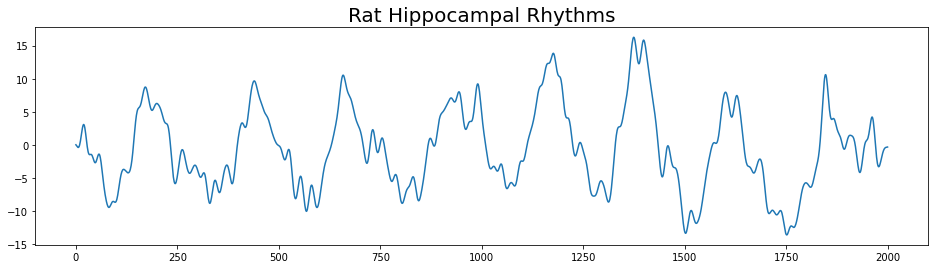

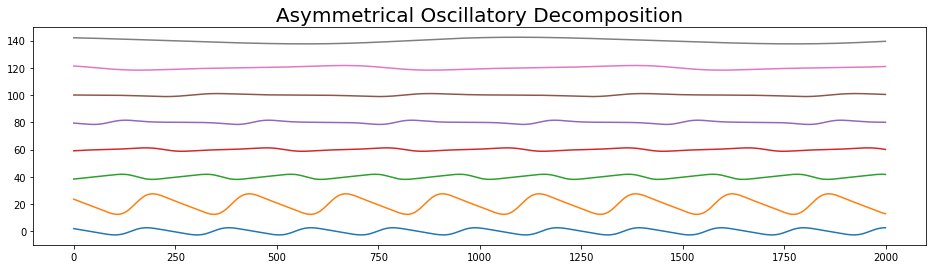

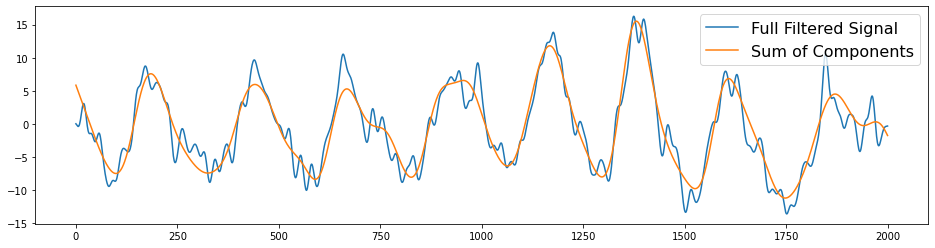

In [2]:
# Load data
file_path_dat = "/home/rph/Projects/bycycle/sim_nbs/crcns/hc2/ec013.527/ec013.527.dat"
num_channels = 31
fs = 20000

with open(file_path_dat, mode='rb') as file: 
    file_content = file.read()
    
sig = np.frombuffer(file_content, dtype=np.short)
sig = np.reshape(sig, (-1, num_channels)).T

sig = sig[20] / 100

# Slice and downsample
i = 100000
j = i+20000

sig_down = decimate(sig[i:j], 10)
sig_down = filter_signal(sig_down, fs/10, 'lowpass', 100, remove_edges=False)

# Fit
_sig = sig_down.copy()
freqs = np.logspace(np.log(1), np.log(10), 100)[::-1]
sig_osc_fit, params = asym_osc_decomposition(_sig, fs/10, freqs, .2, 2)

# Plot
plt.figure(1, figsize=(16, 4))
plt.plot(sig_down)
plt.title('Rat Hippocampal Rhythms', size=20)

plt.figure(2, figsize=(16, 4))
plt.title('Asymmetrical Modes', size=20)
j = 0
for i in sig_osc_fit:
    plt.plot(i + j)
    j += 20
    
plt.figure(3, figsize=(16, 4))
plt.plot(sig_down, label='Full Filtered Signal')
plt.plot(sig_osc_fit.sum(axis=0), label='Sum of Components')
plt.legend(fontsize=16);